In [1]:
%load_ext autoreload
%autoreload 2

import os
import json
from functools import partial
from pathlib import Path
from typing import List, Dict, Any, Tuple

import jax
import jax.numpy as jnp
import numpy as np
import tensorflow as tf
from ml_collections import ConfigDict, FieldReference
from ml_collections.config_dict import placeholder
from copy import deepcopy

# Your existing JAX/ML imports
from jaxrl_m.agents import agents
from jaxrl_m.vision import encoders
from jaxrl_m.data.text_processing import text_processors
from flax.training import checkpoints

from octo.data.dataset import make_interleaved_dataset
from octo.data.oxe import make_oxe_dataset_kwargs_and_weights
from octo.utils.train_callbacks import create_validation_dataset
from octo.utils.train_utils import filter_eval_datasets
from octo.data.utils.data_utils import NormalizationType

2025-07-03 10:22:17.595981: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-03 10:22:17.596636: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-03 10:22:17.732659: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-03 10:22:20.210503: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Core scientific computing (likely already available)
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib

#import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import PCA

# Image processing (JAX/NumPy compatible)
from PIL import Image, ImageEnhance
import cv2

# TensorFlow Hub for language embeddings + Transformers for CLIP
import tensorflow_hub as hub
from transformers import TFCLIPModel, CLIPProcessor

# Setup
tf.config.set_visible_devices([], "GPU")  # Disable TF GPU usage for JAX
print(f"JAX backend: {jax.default_backend()}")
print(f"JAX devices: {jax.local_devices()}")

BATCH_SIZE=1024  # Total batch size (will be divided by ensemble_size)
ENSEMBLE_SIZE=8  # One model per GPU
ALGORITHM="ensemble_sarsa"  # Use ensemble config
SEED=44
RESUME_PATH="/V-GPS/results/VGPS_ensemble/VGPS_ensemble_sarsa_bridge_fractal_ens8_b1024s44_20250614_211102"
DATA_DIR="/V-GPS/datasets/open_x",
DATA_MIX="bridge_fractal",


JAX backend: gpu
JAX devices: [cuda(id=0)]


2025-07-03 10:22:34.567437: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [3]:
# Slightly changed in comparison to original, directly pasted in changed parameters
def create_config():
    """Create configuration matching your training setup"""
    return ConfigDict(dict(
        # Model configuration
        agent="sarsa_ensemble",
        agent_kwargs=dict(
            language_conditioned=True,
            goal_conditioned=True,
            early_goal_concat=None,
            shared_goal_encoder=None,
            shared_encoder=False,
            #
            learning_rate=3e-4,
            discount=0.98,
            soft_target_update_rate=5e-3,
            critic_ensemble_size=2,
            use_min_q=True,
            network_kwargs=dict(
                hidden_dims=[256, 256],
                activate_final=True,
                use_layer_norm=False,
            ),
            num_ood_actions=10,
            ood_action_sample_method="uniform",
        ),
        # Text processing
        text_processor="muse_embedding",
        text_processor_kwargs=dict(),
        # Encoder
        encoder="resnetv1-34-bridge-film",
        encoder_kwargs=dict(
            pooling_method="avg",
            add_spatial_coordinates=True,
            act="swish",
        ),
        # Training setup
        ensemble_size=8,
        batch_size=BATCH_SIZE,
        seed=42,
        resume_path=RESUME_PATH,
    ))

def get_dataset_config(window_size=1):
    task_augmentation = dict(
        task_augment_strategy="delete_task_conditioning",
        task_augment_kwargs=dict(
            keep_image_prob=0.5,
        ),
    )

    return {
        # oxe_kwargs will generate dataset_kwargs_list and sampling weights
        "oxe_kwargs": dict(
            data_mix=placeholder(str),
            data_dir=placeholder(str),
            load_camera_views=("primary", "wrist"),
            load_depth=False,
        ),
        "traj_transform_kwargs": dict(
            window_size=window_size,
            action_horizon=1,
            goal_relabeling_strategy="uniform",
            subsample_length=100,
            **task_augmentation,
        ),
        "frame_transform_kwargs": dict(
            resize_size=(256, 256),
            image_dropout_prob=0.0,
            image_augment_kwargs=dict(
                random_resized_crop=dict(scale=[0.8, 1.0], ratio=[0.9, 1.1]),
                random_brightness=[0.2],
                random_contrast=[0.8, 1.2],
                random_saturation=[0.8, 1.2],
                random_hue=[0.1],
                augment_order=[
                    "random_resized_crop",
                    "random_brightness",
                    "random_contrast",
                    "random_saturation",
                    "random_hue",
                ],
            ),
            num_parallel_calls=200,
        ),
        "traj_transform_threads": 48,  # shared between all datasets
        "traj_read_threads": 48,  # shared between all datasets
        "shuffle_buffer_size": 100000,  # shared between all datasets
        "batch_size": 1024,
        "balance_weights": True,
    }

def update_config(config, **kwargs):
    updates = ConfigDict(kwargs)
    new_config = deepcopy(config)
    new_config.update(updates)
    return new_config


def create_oxe_config():
    """Create complete OXE data configuration"""
    config = get_dataset_config(window_size=1)
    action_dim = FieldReference(7)

    primary_augment_kwargs = dict(
        random_resized_crop=dict(scale=[0.8, 1.0], ratio=[0.9, 1.1]),
        random_brightness=[0.1],
        random_contrast=[0.9, 1.1],
        random_saturation=[0.9, 1.1],
        random_hue=[0.05],
        augment_order=[
            "random_resized_crop",
            "random_brightness",
            "random_contrast",
            "random_saturation",
            "random_hue",
        ],
    )
   
    del config["frame_transform_kwargs"]["resize_size"]
    del config["frame_transform_kwargs"]["image_augment_kwargs"]

    config["frame_transform_kwargs"]["resize_size"] = {
        "primary": (256, 256),
    }
    config["frame_transform_kwargs"]["image_augment_kwargs"] = {
        "primary": primary_augment_kwargs,
    }

    config = update_config(
        config,
        oxe_kwargs=dict(
            data_dir="/V-GPS/datasets/open_x",
            data_mix="bridge_fractal",
            load_camera_views=("primary", ),
            load_depth=False,
            force_recompute_dataset_statistics=False,
            discount=0.98,
            num_final_repeat=3,
            action_proprio_normalization_type=NormalizationType.BOUNDS,
        ),
        traj_transform_kwargs=dict(
            window_size=1,
            action_horizon=1,
            max_action_dim=action_dim,
            task_augment_strategy="delete_task_conditioning",
            task_augment_kwargs=dict(
                keep_image_prob=0.0,
            ),
            goal_relabeling_strategy=None,
        ),
        frame_transform_kwargs=dict(
            image_dropout_prob=0.0,
        ),
        batch_size=BATCH_SIZE,
        shuffle_buffer_size=50000,
        balance_weights=True,
    )
    return ConfigDict(config)

FLAGS = create_config()
oxe_config = create_oxe_config()

In [28]:
class JAXDiversityMeasurer:
    """JAX/TensorFlow-based diversity measurement with OpenAI CLIP"""
    
    def __init__(self):
        self.setup_models()
        self.visual_kmeans = None
        self.reference_language_embedding = None
        
    def setup_models(self):
        """Initialize models - OpenAI CLIP + Universal Sentence Encoder"""
        print("Loading OpenAI CLIP model...")
        self.clip_model = TFCLIPModel.from_pretrained("openai/clip-vit-base-patch32")
        self.clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
        
        print("Loading Multilingual Universal Sentence Encoder...")
        # self.language_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual/3")
        self.language_model = text_processors["muse_embedding"]()

        
    def embed_images(self, images: List[np.ndarray]) -> np.ndarray:
        """Embed images using OpenAI CLIP"""
        pil_images = []
        for img in images:
            # Remove singleton batch dimension: (1, 256, 256, 3) -> (256, 256, 3)
            img = np.squeeze(img)
            # Convert to PIL (images are already uint8 from dataset)
            pil_images.append(Image.fromarray(img))
        
        # Process images in batches
        batch_size = 32
        embeddings = []
        
        for i in range(0, len(pil_images), batch_size):
            batch = pil_images[i:i+batch_size]
            inputs = self.clip_processor(images=batch, return_tensors="tf", padding=True)
            outputs = self.clip_model.get_image_features(**inputs)
            embeddings.append(outputs.numpy())
        
        return np.vstack(embeddings)
    
    def embed_trajectories(self, trajectories_data: List[Dict]) -> np.ndarray:
        """Embed trajectories by concatenating first+last image embeddings"""
        first_images = [traj['first_image'] for traj in trajectories_data]
        last_images = [traj['last_image'] for traj in trajectories_data]
        
        print(f"Embedding {len(first_images)} first images...")
        first_embeddings = self.embed_images(first_images)
        
        print(f"Embedding {len(last_images)} last images...")  
        last_embeddings = self.embed_images(last_images)
        
        # Concatenate embeddings
        trajectory_embeddings = np.concatenate([first_embeddings, last_embeddings], axis=1) # (1024, traj_length)

        return trajectory_embeddings
    
    def embed_language(self, texts: List[str]) -> np.ndarray:
        """Embed language using Multilingual Universal Sentence Encoder"""
        embeddings = self.language_model.encode(texts)
        return embeddings
    
    def fit_reference_clustering(self, reference_trajectories: List[Dict], k: int = 1000):
        """Fit k-means clustering on reference dataset and compute reference language embedding"""
        print(f"Fitting visual clustering with k={k} on {len(reference_trajectories)} trajectories...")
        
        # Visual clustering
        visual_embeddings = self.embed_trajectories(reference_trajectories)
        print(f"DEBUG: Visual embeddings shape: {visual_embeddings.shape}")
        print(f"DEBUG: Visual embeddings stats - mean: {visual_embeddings.mean():.4f}, std: {visual_embeddings.std():.4f}")
        
        n_samples = visual_embeddings.shape[0]
        # Use reasonable number of clusters - not more than n_samples/4
        k_actual = min(k, max(10, n_samples // 4))
        
        print(f"DEBUG: Using {k_actual} clusters for {n_samples} samples")
        
        self.visual_kmeans = KMeans(n_clusters=k_actual, random_state=42, n_init=10)
        self.visual_kmeans.fit(visual_embeddings)
        
        print(f"DEBUG: K-means inertia: {self.visual_kmeans.inertia_:.4f}")
        
        # Reference language embedding (average)
        languages = [traj['language'] for traj in reference_trajectories if traj['language'].strip()]  # Filter empty strings
        print(f"DEBUG: Found {len(languages)} non-empty language instructions out of {len(reference_trajectories)}")
        
        if len(languages) > 0:
            language_embeddings = self.embed_language(languages)
            self.reference_language_embedding = np.mean(language_embeddings, axis=0)
            print(f"DEBUG: Language embeddings shape: {language_embeddings.shape}")
            print(f"DEBUG: Reference language embedding shape: {self.reference_language_embedding.shape}")
        else:
            print("WARNING: No valid language instructions found!")
            self.reference_language_embedding = None
        
        print(f"Visual clustering fitted with {k_actual} clusters")
        print(f"Reference language embedding computed from {len(languages)} prompts")
        
        return visual_embeddings, language_embeddings if len(languages) > 0 else None
    
    def compute_visual_diversity_scores(self, trajectories: List[Dict]) -> np.ndarray:
        """Compute visual diversity scores using fitted k-means"""
        if self.visual_kmeans is None:
            raise ValueError("Must call fit_reference_clustering first!")
            
        visual_embeddings = self.embed_trajectories(trajectories)
        
        # Compute distances to nearest cluster centers
        cluster_labels = self.visual_kmeans.predict(visual_embeddings)
        distances = np.array([
            np.linalg.norm(visual_embeddings[i] - self.visual_kmeans.cluster_centers_[cluster_labels[i]])
            for i in range(len(trajectories))
        ])
        
        return distances
    
    def compute_language_diversity_scores(self, texts: List[str]) -> np.ndarray:
        """Compute language diversity scores as distance to reference embedding"""
        if self.reference_language_embedding is None:
            raise ValueError("Must call fit_reference_clustering first!")
            
        embeddings = self.embed_language(texts)
        distances = np.array([
            np.linalg.norm(emb - self.reference_language_embedding)
            for emb in embeddings
        ])
        
        return distances


In [5]:
def extract_trajectory_data(dataset_name: str, max_trajectories: int = None, keep_full_trajectory=False, keep_raw_instruction=False):
    """Extract trajectory data efficiently from dataset
    
    Args:
        dataset_name: "bridge" or "fractal"
        max_trajectories: Max number to extract, None for all
        keep_full_trajectory: If True, also keep full trajectory (memory intensive)
    """
    
    FLAGS = create_config()
    oxe_config = create_oxe_config()
    
    # Create dataset kwargs
    (dataset_kwargs_list, sample_weights) = make_oxe_dataset_kwargs_and_weights(**oxe_config["oxe_kwargs"])
        
    # Filter for specific dataset
    if dataset_name == "bridge":
        filter_names = ["bridge_dataset"]
    elif dataset_name == "fractal":
        filter_names = ["fractal20220817_data"]
    else:
        raise ValueError(f"Unknown dataset: {dataset_name}")
    
    val_datasets_kwargs_list, _ = filter_eval_datasets(dataset_kwargs_list, sample_weights, filter_names)
    
    # Create validation dataset
    val_data = create_validation_dataset(
        val_datasets_kwargs_list[0],
        oxe_config["traj_transform_kwargs"],
        oxe_config["frame_transform_kwargs"],
        train=False
    )
    
    # Create trajectory iterator
    val_traj_iter = val_data.iterator()
    
    trajectories = []
    print(f"Extracting trajectories from {dataset_name}...")
    print(f"Keep full trajectory: {keep_full_trajectory}")
    
    for i, batch in enumerate(val_traj_iter):
        if max_trajectories is not None and i >= max_trajectories:
            break
            
        images = batch["observation"]["image_primary"].squeeze()  # Shape: (traj_len, 1, 256, 256, 3)
        language_raw = batch["task"]["language_instruction"]  # Shape: (traj_len,) of bytes
        actions = batch['action'].squeeze()

        # Take first language instruction and decode from bytes
        language = language_raw[0].decode("utf-8")
        
        # Extract first and last images efficiently
        first_image = images[0]   # Shape: (1, 256, 256, 3)
        last_image = images[-1]   # Shape: (1, 256, 256, 3)
        first_action, last_action = actions[0], actions[-1]
        
        trajectory_data = {
            'first_image': first_image,
            'last_image': last_image,
            'first_action': first_action,
            'last_action': last_action,
            'language': language,
            'dataset': dataset_name,
            'traj_length': images.shape[0],
            'action': actions
        }
        
        if keep_raw_instruction:
            trajectory_data["language_bytes"] = language_raw
        # Optionally keep full trajectory
        if keep_full_trajectory:
            trajectory_data['images'] = images
        
        trajectories.append(trajectory_data)
        
        if (i + 1) % 1000 == 0:
            print(f"Extracted {i + 1} trajectories...")
    
    print(f"Extracted {len(trajectories)} trajectories from {dataset_name}")
    return trajectories


In [6]:
bridge_trajectories_full = extract_trajectory_data(
    "bridge", 
    max_trajectories=None,  # Extract all
    keep_full_trajectory=False  # Save memory
)

Cause: Unable to locate the source code of <function _gcd_import at 0x7fa79a9a7400>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function _gcd_import at 0x7fa79a9a7400>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function _gcd_import at 0x7fa79a9a7400>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
save_dir in data_utils is /V-GPS/datasets/open_x/bridge_dataset/1.0.0
using path: /V-GPS/datasets/open_x/bridge_dataset/1.0.0/dataset_statistics_8f4411cce30fcceb8ec926ca1c9c84df0aa283c416d622de05dcb90a6f6e0d29.json


Extracting trajectories from bridge...
Keep full trajectory: False
Extracted 1000 trajectories...
Extracted 2000 trajectories...
Extracted 3000 trajectories...
Extracted 4000 trajectories...
Extracted 5000 trajectories...
Extracted 6000 trajectories...
Extracted 6872 trajectories from bridge


In [7]:
measurer = JAXDiversityMeasurer()

Loading OpenAI CLIP model...


All model checkpoint layers were used when initializing TFCLIPModel.

All the layers of TFCLIPModel were initialized from the model checkpoint at openai/clip-vit-base-patch32.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCLIPModel for predictions without further training.
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading Multilingual Universal Sentence Encoder...


In [8]:
ref_visual_embeddings, ref_language_embeddings = measurer.fit_reference_clustering(
    bridge_trajectories_full, k=500  # Use reasonable number of clusters for ~7k samples
)

Fitting visual clustering with k=500 on 6872 trajectories...
Embedding 6872 first images...
Embedding 6872 last images...
Final trajectory embeddings shape: (6872, 1024)
DEBUG: Visual embeddings shape: (6872, 1024)
DEBUG: Visual embeddings stats - mean: -0.0112, std: 0.4742
DEBUG: Using 500 clusters for 6872 samples
DEBUG: K-means inertia: 143640.2344
DEBUG: Found 5147 non-empty language instructions out of 6872
<class 'numpy.ndarray'>
(5147, 512)
DEBUG: Language embeddings shape: (5147, 512)
DEBUG: Reference language embedding shape: (512,)
Visual clustering fitted with 500 clusters
Reference language embedding computed from 5147 prompts


In [ ]:
# ============================================================================
# Test Distance measure:
# 1) Visual: New Images diversity score = distance to closest cluster (K=1000) from reference dataset  (2 images per traj, start and end image concatenated)
# 2) Language: average MUSE embeddingdistance is calculated over all pairs of prompts
# that is N*(N-1)/2 computations - counts each unordered pair only once
# ============================================================================

def test_distance_measures():
    """Quick test with minimal data"""
    # 1. Load the datasets Bridgesv2 and fractals (reference dataset)
    # 2. extract needed information: {first image, last image} per trajectory, language prompts
    # 3. Create embeddings
    # 4. For images do kMeans k=1000 clustering and for languages compute average embedding
    # 5. Include some sanity checks: Show some image samples and their embeddings (distances), same for prompts but here you can invent some prompts
    #    compare them to average embedding. If feasible add plotting of clustering (by applying dimensionality reduction before)
    # 6. The goal is that we can later on measure the degree of "novelness" of new / OOD samples by comparing computing distances wrt- reference dataset 

#### Prepare Uncertainty estimation with Q-Ensemble

In [9]:
# measurer = JAXDiversityMeasurer()
text_processor = measurer.language_model

In [10]:
# Ensemble Loading 
# 1. We first need to initialize ensemble randomly 
# 2. Load checkpoint for each ensemble member 

def process_text(batch, keep_language_str=False):
    decoded_strings = [s.decode("utf-8") for s in batch["goals"]["language"]]
    if text_processor is not None:
        batch["goals"]["language"] = text_processor.encode(decoded_strings)
    if keep_language_str:
        batch["goals"]["language_str"] = decoded_strings
    return batch

def process_oxe_batch(batch, keep_language_str=False, training=False):
    """Preprocess training or validation batch. Set keep_language_str=True for validation."""
    ensemble_size = ENSEMBLE_SIZE
    
    def reshape_to_ensemble(x):
        return x.reshape(ensemble_size, batch_size_per_member, *x.shape[1:])

    pre_batch = {
        "actions": batch["action"].squeeze(),
        "next_actions": batch["next_action"].squeeze(),
        "goals": {
            "language": batch["task"]["language_instruction"]
        },
        "mc_returns": batch["mc_return"],
        "observations": {"image": batch["observation"]["image_primary"].squeeze()},
        "next_observations": {"image": batch["next_observation"]["image_primary"].squeeze()},
        "rewards": batch["reward"],
        "masks": batch["td_mask"],
    }

    processed_batch = process_text(pre_batch, keep_language_str=keep_language_str)

    if training: # in training, we want to reshape (batch_size,) → (ensemble_size, batch_size // ensemble_size)
        ensemble_batch = jax.tree_map(reshape_to_ensemble, processed_batch)
    else: # in validation, we want to keep the batch size as is as we are duplicating the batch
        ensemble_batch = processed_batch 

    return ensemble_batch

def create_ensemble_agents(ensemble_size, rng, template_batch, encoder_def, agent_class, agent_kwargs):
    """
    Create ensemble agents with vectorized creation if available.
    """
    print("Creating ensemble agents...")
    
    # Check if agent class supports vectorized ensemble creation
    if hasattr(agent_class, 'create_ensemble_vectorized'):
        print("Using vectorized ensemble agent creation")
        ensemble_agents = agent_class.create_ensemble_vectorized(
            base_rng=rng,
            ensemble_size=ensemble_size,
            observations=template_batch["observations"],
            actions=template_batch["actions"],
            encoder_def=encoder_def,
            goals=template_batch["goals"],
            **agent_kwargs
        )
    else:
        print("Using standard ensemble agent creation")
        agent_rngs = jax.random.split(rng, ensemble_size)
        
        agents_list = []
        for member_idx, agent_rng in enumerate(agent_rngs):
            agent = agent_class.create(
                rng=agent_rng,
                observations=template_batch["observations"],
                goals=template_batch["goals"],
                actions=template_batch["actions"],
                encoder_def=encoder_def,
                **agent_kwargs,
            )
            agents_list.append(agent)
        
        # Stack into ensemble structure for pmap
        ensemble_agents = jax.tree_map(lambda *args: jnp.stack(args, axis=0), *agents_list)
    
    return ensemble_agents

def load_ensemble_agent(resume_path: str, config: ConfigDict, data_mix: str = "bridge_fractal", data_dir: str = "/path/to/data"):
    """Load ensemble agent from checkpoint using your existing pipeline"""
    
    print(f"Loading ensemble from {resume_path}...")
    
    ensemble_size = config.ensemble_size
    batch_size_per_member = config.batch_size // ensemble_size
    
    # Create encoder
    encoder_def = encoders[config.encoder](**config.encoder_kwargs)
    
    # Setup text processor
    text_processor = None
    if config.get("text_processor"):
        text_processor = text_processors[config.text_processor](**config.text_processor_kwargs)
    
    # Create dataset to get real template batch
    if "oxe_kwargs" in FLAGS.oxedata_config:
        (
            FLAGS.oxedata_config["dataset_kwargs_list"],
            FLAGS.oxedata_config["sample_weights"],
        ) = make_oxe_dataset_kwargs_and_weights(**FLAGS.oxedata_config["oxe_kwargs"])
        oxe_kwargs = FLAGS.oxedata_config["oxe_kwargs"]
        del FLAGS.oxedata_config["oxe_kwargs"]
    
    train_data = make_interleaved_dataset(
        dataset_kwargs_list=FLAGS.oxedata_config["dataset_kwargs_list"],
        sample_weights=FLAGS.oxedata_config["sample_weights"],
        train=True,
        shuffle_buffer_size=1000,
        batch_size=config.batch_size,
        balance_weights=True,
        traj_transform_kwargs={},
        frame_transform_kwargs={}
    )
    
    # Create iterator and get example batch
    train_iterator = map(partial(process_oxe_batch, training=True), train_data.iterator(prefetch=0))

    example_batch = next(train_iterator)  # Already ensemble-shaped because of process_oxe_batch's reshape !
    template_batch = jax.tree_map(lambda x: x[0], example_batch)  # Extract single member for template

    print(f"example_batch batch shape: {jax.tree_map(lambda x: x.shape, example_batch)}")
    print(f"Template batch shape: {jax.tree_map(lambda x: x.shape, template_batch)}")
    
    # Get agent class
    agent_class = agents[config.agent]
    
    # Create ensemble agents
    rng = jax.random.PRNGKey(config.seed)
    ensemble_agents = create_ensemble_agents(
        ensemble_size, rng, template_batch, encoder_def, agent_class, config.agent_kwargs
    )
    
    # Restore from checkpoints following your exact pattern
    print("Restoring ensemble agents from checkpoint...")
    restored_agents = []
    for member_idx in range(ensemble_size):
        member_checkpoint_path = os.path.join(resume_path, f"ensemble_member_{member_idx}")
        if tf.io.gfile.exists(member_checkpoint_path):
            agent = jax.tree_map(lambda x: x[member_idx], ensemble_agents)
            agent = checkpoints.restore_checkpoint(member_checkpoint_path, target=agent)
            print(f"Restored ensemble member {member_idx} from {member_checkpoint_path}")
        else:
            print(f"Checkpoint not found for member {member_idx}, using random init")
            agent = jax.tree_map(lambda x: x[member_idx], ensemble_agents)
        restored_agents.append(agent)
    
    ensemble_agents = jax.tree_map(lambda *args: jnp.stack(args, axis=0), *restored_agents)

    print("Ensemble loading complete!")
    return ensemble_agents, train_iterator

In [11]:
ensemble_size = FLAGS.ensemble_size
batch_size_per_member = FLAGS.batch_size // ensemble_size
FLAGS.oxedata_config = oxe_config
ensemble_agents, train_iterator = load_ensemble_agent(resume_path=RESUME_PATH, config=FLAGS, data_mix=DATA_MIX, data_dir=DATA_DIR)

Loading ensemble from /V-GPS/results/VGPS_ensemble/VGPS_ensemble_sarsa_bridge_fractal_ens8_b1024s44_20250614_211102...
save_dir in data_utils is /V-GPS/datasets/open_x/bridge_dataset/1.0.0
using path: /V-GPS/datasets/open_x/bridge_dataset/1.0.0/dataset_statistics_8f4411cce30fcceb8ec926ca1c9c84df0aa283c416d622de05dcb90a6f6e0d29.json
save_dir in data_utils is /V-GPS/datasets/open_x/fractal20220817_data/0.1.0
using path: /V-GPS/datasets/open_x/fractal20220817_data/0.1.0/dataset_statistics_0b80dc9feb0bcf09d2f3341cfc9327c8b959288b808ff3fae252ddc322947ccf.json

######################################################################################
# Loading the following 2 datasets (incl. sampling weight):                         #
# bridge_dataset: ==========================================================0.517388 #
# fractal20220817_data: ====================================================0.482612 #
######################################################################################



example_batch batch shape: {'actions': (8, 128, 7), 'goals': {'language': (8, 128, 512)}, 'masks': (8, 128), 'mc_returns': (8, 128), 'next_actions': (8, 128, 7), 'next_observations': {'image': (8, 128, 256, 256, 3)}, 'observations': {'image': (8, 128, 256, 256, 3)}, 'rewards': (8, 128)}
Template batch shape: {'actions': (128, 7), 'goals': {'language': (128, 512)}, 'masks': (128,), 'mc_returns': (128,), 'next_actions': (128, 7), 'next_observations': {'image': (128, 256, 256, 3)}, 'observations': {'image': (128, 256, 256, 3)}, 'rewards': (128,)}
Creating ensemble agents...
Using vectorized ensemble agent creation


/opt/conda/envs/vgps/lib/python3.10/site-packages/flax/core/lift.py:140: RuntimeWarning: kwargs are not supported in vmap, so "train" is(are) ignored
  warnings.warn(msg.format(name, ', '.join(kwargs.keys())), RuntimeWarning)


Restoring ensemble agents from checkpoint...


Restored ensemble member 0 from /V-GPS/results/VGPS_ensemble/VGPS_ensemble_sarsa_bridge_fractal_ens8_b1024s44_20250614_211102/ensemble_member_0


Restored ensemble member 1 from /V-GPS/results/VGPS_ensemble/VGPS_ensemble_sarsa_bridge_fractal_ens8_b1024s44_20250614_211102/ensemble_member_1


Restored ensemble member 2 from /V-GPS/results/VGPS_ensemble/VGPS_ensemble_sarsa_bridge_fractal_ens8_b1024s44_20250614_211102/ensemble_member_2


Restored ensemble member 3 from /V-GPS/results/VGPS_ensemble/VGPS_ensemble_sarsa_bridge_fractal_ens8_b1024s44_20250614_211102/ensemble_member_3


Restored ensemble member 4 from /V-GPS/results/VGPS_ensemble/VGPS_ensemble_sarsa_bridge_fractal_ens8_b1024s44_20250614_211102/ensemble_member_4


Restored ensemble member 5 from /V-GPS/results/VGPS_ensemble/VGPS_ensemble_sarsa_bridge_fractal_ens8_b1024s44_20250614_211102/ensemble_member_5


Restored ensemble member 6 from /V-GPS/results/VGPS_ensemble/VGPS_ensemble_sarsa_bridge_fractal_ens8_b1024s44_20250614_211102/ensemble_member_6


Restored ensemble member 7 from /V-GPS/results/VGPS_ensemble/VGPS_ensemble_sarsa_bridge_fractal_ens8_b1024s44_20250614_211102/ensemble_member_7
Ensemble loading complete!


In [154]:
# example_batch = next(train_iterator)
# template_batch = jax.tree_map(lambda x: x[0], example_batch)  # Extract sub batch for single member
# duplicate_batch = jax.tree_map(
#         lambda x: jnp.repeat(x[None], ensemble_size, axis=0), 
#         template_batch
#     ) # adds (ensemble_size, ...) dimension through duplicating
# # duplicate_batch['actions'] is (ensemble_size, batch_size, action_dim) = (8, 128, 7)
# sample = jax.tree_map(lambda x: x[:,0,...], duplicate_batch)
# # jax.tree_map(lambda x: x.shape, duplicate_batch)

In [12]:
# jax.tree_map(lambda x: x.shape, sample)
def add_extra_batch_dim(tree):
    """Add Batch dimension"""
    return jax.tree_map(lambda x: jnp.expand_dims(x, axis=1), tree)


In [13]:
vmapped_forward_critic = jax.vmap(lambda agent, batch, rng_key: agent.forward_critic(agent._include_goals_in_obs(batch, "observations"), 
                            batch["actions"], rng=rng_key, train=False)
                        )

def compute_ensemble_uncertainty(ensemble_agent, batch, ensemble_size=8):
    """expects traj dict, jax tree-like structure with values of dimension: (ensemble_size, batch_size, action_dim/obs_dim/reward_dim)""" 
    rng = jax.random.PRNGKey(0) # TODO: should we use passed rng or a fixed one? cql.py also uses PRNGKey(0) here
    val_rngs = jax.random.split(rng, ensemble_size)
    q_values = vmapped_forward_critic(ensemble_agent, batch, val_rngs)
    assert jnp.ndim(q_values) == 3
    disagreement = jnp.std(jnp.mean(q_values, axis=[1,2])) # We get back (ensemble_size, 2, batch_size) where I assume 2 is from number of critic networks
    return disagreement
# q_values = compute_ensemble_uncertainty(ensemble_agents, duplicate_batch, ensemble_size)

#### How do image augmentations influence OOD predictions?

In [17]:
# measurer
# measurer.visual_kmeans, measurer.reference_language_embedding

# 1) Load eval trajectories,
# 2) compute diversity scores
# 3) compute ensemble uncertainty 
# 4) compare results

In [ ]:
dataset_name = "bridge" 
num_trajectories = 20
# 1) Load eval trajectories
eval_trajectories = extract_trajectory_data(dataset_name, max_trajectories=num_trajectories, keep_raw_instruction=True)

# 2) Compute diversity scores
visual_diversity = measurer.compute_visual_diversity_scores(eval_trajectories)
languages = [traj['language'] for traj in eval_trajectories]
language_diversity = measurer.compute_language_diversity_scores(languages)

In [ ]:
# 3) Compute ensemble uncertainty
text_processor = measurer.language_model
uncertainty_scores = []

for traj in eval_trajectories:
    first_image = traj['first_image']
    last_image = traj['last_image']
    images = np.stack([first_image, last_image])   # (2, 256, 256, 3)
    
    first_action = traj['first_action']
    last_action = traj['last_action']

    actions = np.stack([first_action, last_action])   # (2, 256, 256, 3)
    language_bytes = np.array([traj['language_bytes'][0], traj['language_bytes'][0]])

    batch = {
        "actions": actions,
        "observations": {"image": images},
        "goals": {"language": language_bytes}
    }
    
    decoded_strings = [s.decode("utf-8") for s in batch["goals"]["language"]]
    batch["goals"]["language"] = text_processor.encode(decoded_strings)
    
    duplicate_batch = jax.tree_map(lambda x: jnp.repeat(jnp.array(x)[None], 8, axis=0), batch)
    try:
        uncertainty = compute_ensemble_uncertainty(ensemble_agents, duplicate_batch, ensemble_size=8)
        uncertainty_scores.append(float(uncertainty))
    except:
        uncertainty_scores.append(None)

# 4) Filter valid results and compute correlations
valid_indices = [i for i, u in enumerate(uncertainty_scores) if u is not None]
valid_visual = visual_diversity[valid_indices]
valid_language = language_diversity[valid_indices]
valid_uncertainty = [uncertainty_scores[i] for i in valid_indices]

visual_corr = np.corrcoef(valid_visual, valid_uncertainty)[0, 1]
language_corr = np.corrcoef(valid_language, valid_uncertainty)[0, 1]

# Results
print(f"Dataset: {dataset_name}")
print(f"Valid eval_trajectories: {len(valid_uncertainty)}")
print(f"Visual-Uncertainty correlation: {visual_corr:.4f}")
print(f"Language-Uncertainty correlation: {language_corr:.4f}")

# Store results
bridge_results = {
    'visual_diversity': valid_visual,
    'language_diversity': valid_language,
    'uncertainty': valid_uncertainty,
    'correlations': {'visual': visual_corr, 'language': language_corr}
}

In [31]:
# 1) load measurer with bridge val set as reference data set
# 2) execute eval pipeline with fractals eval_trajectories BUT multiple times while augmenting the observations:
# a) baseline run: dont augment any observations
# b-e) apply standard augmentations on both first and last image (gaussian noise, brightness, contrast for example)
# In the end prints of uncertainty, diversity scores, correlation between those is enough


def evaluate_ood_with_augmentation(eval_trajectories, measurer, ensemble_agents, 
                                 compute_ensemble_uncertainty, augment_fn=None, 
                                 augment_name="baseline"):
    """Evaluate OOD detection with optional image augmentation - single iteration"""
    
    text_processor = measurer.language_model
    augmented_trajectories = []
    uncertainty_scores = []
    
    # Single iteration over trajectories
    for traj in eval_trajectories:
        # Apply augmentation if specified
        if augment_fn is not None:
            first_image = augment_fn(traj['first_image'])
            last_image = augment_fn(traj['last_image'])
        else:
            first_image = traj['first_image']
            last_image = traj['last_image']
        
        # Store augmented trajectory for diversity computation
        aug_traj = traj.copy()
        aug_traj['first_image'] = first_image
        aug_traj['last_image'] = last_image
        augmented_trajectories.append(aug_traj)
        
        # Compute uncertainty using augmented images
        images = np.stack([first_image, last_image])
        first_action = traj['first_action']
        last_action = traj['last_action']
        actions = np.stack([first_action, last_action])
        language_bytes = np.array([traj['language_bytes'][0], traj['language_bytes'][0]])
        
        batch = {
            "actions": actions,
            "observations": {"image": images},
            "goals": {"language": language_bytes}
        }
        
        decoded_strings = [s.decode("utf-8") for s in batch["goals"]["language"]]
        batch["goals"]["language"] = text_processor.encode(decoded_strings)
        
        duplicate_batch = jax.tree_map(lambda x: jnp.repeat(jnp.array(x)[None], 8, axis=0), batch)
        
        try:
            uncertainty = compute_ensemble_uncertainty(ensemble_agents, duplicate_batch, ensemble_size=8)
            uncertainty_scores.append(float(uncertainty))
        except:
            uncertainty_scores.append(None)
    
    # Compute diversity scores in batch (efficient)
    visual_diversity = measurer.compute_visual_diversity_scores(augmented_trajectories)
    # languages = [traj['language'] for traj in eval_trajectories]
    # language_diversity = measurer.compute_language_diversity_scores(languages)
    
    # Filter valid results and compute correlations
    valid_indices = [i for i, u in enumerate(uncertainty_scores) if u is not None]
    valid_visual = visual_diversity[valid_indices]
    # valid_language = language_diversity[valid_indices]
    valid_uncertainty = [uncertainty_scores[i] for i in valid_indices]
    
    visual_corr = np.corrcoef(valid_visual, valid_uncertainty)[0, 1]
    # language_corr = np.corrcoef(valid_language, valid_uncertainty)[0, 1]
    
    # Print results
    print(f"Augmentation: {augment_name}")
    print(f"  Valid trajectories: {len(valid_uncertainty)}")
    print(f"  Visual diversity: mean={np.mean(valid_visual):.4f}, std={np.std(valid_visual):.4f}")
    # print(f"  Language diversity: mean={np.mean(valid_language):.4f}, std={np.std(valid_language):.4f}")
    print(f"  Uncertainty: mean={np.mean(valid_uncertainty):.4f}, std={np.std(valid_uncertainty):.4f}")
    print(f"  Visual-Uncertainty correlation: {visual_corr:.4f}")
    # print(f"  Language-Uncertainty correlation: {language_corr:.4f}")
    print()
    
    return {
        'visual_diversity': valid_visual,
        # 'language_diversity': valid_language,
        'uncertainty': valid_uncertainty,
        'correlations': {'visual': visual_corr, },# 'language': language_corr
        'name': augment_name
    }

In [32]:
def gaussian_noise_augment(image, noise_std=0.1):
    """Add gaussian noise to image"""
    image = np.squeeze(image).astype(np.float32) / 255.0
    noise = np.random.normal(0, noise_std, image.shape)
    augmented = np.clip(image + noise, 0, 1)
    return (augmented * 255).astype(np.uint8)[None, ...]

def brightness_augment(image, brightness_factor=1.5):
    """Adjust brightness of image"""
    image = np.squeeze(image).astype(np.float32)
    augmented = np.clip(image * brightness_factor, 0, 255)
    return augmented.astype(np.uint8)[None, ...]

def contrast_augment(image, contrast_factor=1.5):
    """Adjust contrast of image"""
    image = np.squeeze(image).astype(np.float32)
    mean = np.mean(image)
    augmented = np.clip((image - mean) * contrast_factor + mean, 0, 255)
    return augmented.astype(np.uint8)[None, ...]

def saturation_augment(image, saturation_factor=1.5):
    """Adjust saturation of image"""
    image = np.squeeze(image).astype(np.float32) / 255.0
    gray = np.dot(image, [0.299, 0.587, 0.114])
    gray = np.expand_dims(gray, axis=2)
    augmented = gray + saturation_factor * (image - gray)
    augmented = np.clip(augmented, 0, 1)
    return (augmented * 255).astype(np.uint8)[None, ...]

save_dir in data_utils is /V-GPS/datasets/open_x/fractal20220817_data/0.1.0
using path: /V-GPS/datasets/open_x/fractal20220817_data/0.1.0/dataset_statistics_0b80dc9feb0bcf09d2f3341cfc9327c8b959288b808ff3fae252ddc322947ccf.json


Extracting trajectories from fractal...
Keep full trajectory: False
Extracted 1 trajectories from fractal


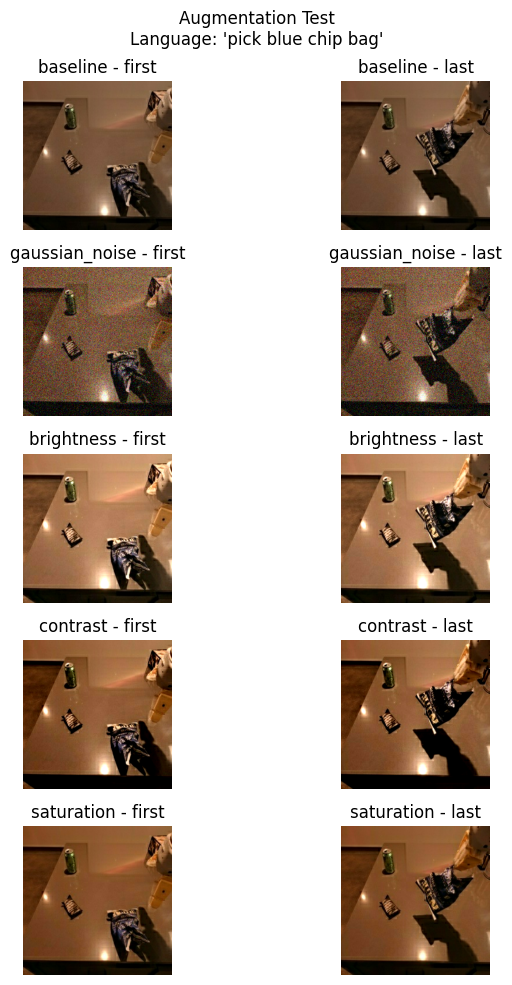

In [17]:
def test_augmentations():
    """Test and visualize augmentations on one trajectory"""
    
    # Load one trajectory
    test_traj = extract_trajectory_data("fractal", max_trajectories=1, keep_raw_instruction=True)[0]
    
    # Get original images
    first_img = np.squeeze(test_traj['first_image'])
    last_img = np.squeeze(test_traj['last_image'])
    
    # Define augmentations
    augmentations = [
        ("baseline", lambda x: x),
        ("gaussian_noise", gaussian_noise_augment),
        ("brightness", brightness_augment),
        ("contrast", contrast_augment),
        ("saturation", saturation_augment)
    ]
    
    # Create plot
    fig, axes = plt.subplots(len(augmentations), 2, figsize=(8, 10))
    
    for i, (name, aug_fn) in enumerate(augmentations):
        if name == "baseline":
            aug_first = first_img
            aug_last = last_img
        else:
            aug_first = np.squeeze(aug_fn(test_traj['first_image']))
            aug_last = np.squeeze(aug_fn(test_traj['last_image']))
        
        # Plot first image
        axes[i, 0].imshow(aug_first)
        axes[i, 0].set_title(f"{name} - first")
        axes[i, 0].axis('off')
        
        # Plot last image
        axes[i, 1].imshow(aug_last)
        axes[i, 1].set_title(f"{name} - last")
        axes[i, 1].axis('off')
    
    plt.suptitle(f"Augmentation Test\nLanguage: '{test_traj['language']}'")
    plt.tight_layout()
    plt.show()

# Run the test
test_augmentations()

In [33]:
# Load fractal evaluation trajectories
fractal_eval_trajectories = extract_trajectory_data("fractal", max_trajectories=50, keep_raw_instruction=True)

print("=== OOD Evaluation with Different Augmentations ===\n")

# Run evaluations with different augmentations
results = {}

# Baseline - no augmentation
results['baseline'] = evaluate_ood_with_augmentation(
    fractal_eval_trajectories, measurer, ensemble_agents, 
    compute_ensemble_uncertainty, augment_fn=None, augment_name="baseline"
)

# Gaussian noise
results['gaussian_noise'] = evaluate_ood_with_augmentation(
    fractal_eval_trajectories, measurer, ensemble_agents, 
    compute_ensemble_uncertainty, augment_fn=gaussian_noise_augment, augment_name="gaussian_noise"
)

# Brightness adjustment
results['brightness'] = evaluate_ood_with_augmentation(
    fractal_eval_trajectories, measurer, ensemble_agents, 
    compute_ensemble_uncertainty, augment_fn=brightness_augment, augment_name="brightness"
)

# Contrast adjustment
results['contrast'] = evaluate_ood_with_augmentation(
    fractal_eval_trajectories, measurer, ensemble_agents, 
    compute_ensemble_uncertainty, augment_fn=contrast_augment, augment_name="contrast"
)

# Saturation adjustment
results['saturation'] = evaluate_ood_with_augmentation(
    fractal_eval_trajectories, measurer, ensemble_agents, 
    compute_ensemble_uncertainty, augment_fn=saturation_augment, augment_name="saturation"
)

# Summary comparison
print("=== Summary Comparison ===")
for name, result in results.items():
    print(f"{name:12}: visual_corr={result['correlations']['visual']:6.3f}, "
          # f"lang_corr={result['correlations']['language']:6.3f}, "
          f"uncertainty_mean={np.mean(result['uncertainty']):6.3f}")

save_dir in data_utils is /V-GPS/datasets/open_x/fractal20220817_data/0.1.0
using path: /V-GPS/datasets/open_x/fractal20220817_data/0.1.0/dataset_statistics_0b80dc9feb0bcf09d2f3341cfc9327c8b959288b808ff3fae252ddc322947ccf.json


Extracting trajectories from fractal...
Keep full trajectory: False
Extracted 50 trajectories from fractal
=== OOD Evaluation with Different Augmentations ===



/opt/conda/envs/vgps/lib/python3.10/site-packages/flax/core/lift.py:140: RuntimeWarning: kwargs are not supported in vmap, so "train" is(are) ignored
  warnings.warn(msg.format(name, ', '.join(kwargs.keys())), RuntimeWarning)


Embedding 50 first images...
Embedding 50 last images...
Final trajectory embeddings shape: (50, 1024)
Augmentation: baseline
  Valid trajectories: 50
  Visual diversity: mean=9.4910, std=0.4659
  Uncertainty: mean=0.8165, std=0.7916
  Visual-Uncertainty correlation: 0.2215



/opt/conda/envs/vgps/lib/python3.10/site-packages/flax/core/lift.py:140: RuntimeWarning: kwargs are not supported in vmap, so "train" is(are) ignored
  warnings.warn(msg.format(name, ', '.join(kwargs.keys())), RuntimeWarning)


Embedding 50 first images...
Embedding 50 last images...
Final trajectory embeddings shape: (50, 1024)
Augmentation: gaussian_noise
  Valid trajectories: 50
  Visual diversity: mean=10.6479, std=0.4380
  Uncertainty: mean=0.8597, std=0.8071
  Visual-Uncertainty correlation: 0.3337



/opt/conda/envs/vgps/lib/python3.10/site-packages/flax/core/lift.py:140: RuntimeWarning: kwargs are not supported in vmap, so "train" is(are) ignored
  warnings.warn(msg.format(name, ', '.join(kwargs.keys())), RuntimeWarning)


Embedding 50 first images...
Embedding 50 last images...
Final trajectory embeddings shape: (50, 1024)
Augmentation: brightness
  Valid trajectories: 50
  Visual diversity: mean=9.9160, std=0.5819
  Uncertainty: mean=1.1359, std=0.9246
  Visual-Uncertainty correlation: 0.1506



/opt/conda/envs/vgps/lib/python3.10/site-packages/flax/core/lift.py:140: RuntimeWarning: kwargs are not supported in vmap, so "train" is(are) ignored
  warnings.warn(msg.format(name, ', '.join(kwargs.keys())), RuntimeWarning)


Embedding 50 first images...
Embedding 50 last images...
Final trajectory embeddings shape: (50, 1024)
Augmentation: contrast
  Valid trajectories: 50
  Visual diversity: mean=10.1147, std=0.5920
  Uncertainty: mean=0.8390, std=0.7738
  Visual-Uncertainty correlation: 0.1684



/opt/conda/envs/vgps/lib/python3.10/site-packages/flax/core/lift.py:140: RuntimeWarning: kwargs are not supported in vmap, so "train" is(are) ignored
  warnings.warn(msg.format(name, ', '.join(kwargs.keys())), RuntimeWarning)


Embedding 50 first images...
Embedding 50 last images...
Final trajectory embeddings shape: (50, 1024)
Augmentation: saturation
  Valid trajectories: 50
  Visual diversity: mean=9.9640, std=0.5280
  Uncertainty: mean=0.8714, std=0.8657
  Visual-Uncertainty correlation: 0.2582

=== Summary Comparison ===
baseline    : visual_corr= 0.222, uncertainty_mean= 0.816
gaussian_noise: visual_corr= 0.334, uncertainty_mean= 0.860
brightness  : visual_corr= 0.151, uncertainty_mean= 1.136
contrast    : visual_corr= 0.168, uncertainty_mean= 0.839
saturation  : visual_corr= 0.258, uncertainty_mean= 0.871


#### Load Diffusion Model

In [10]:
import os
os.environ["KERAS_BACKEND"] = "jax"  # or "tensorflow"

import keras
import keras_hub
from keras_hub.models import StableDiffusion3TextToImage
from keras.utils import array_to_img

# Load the model
text_to_image = StableDiffusion3TextToImage.from_preset(
    "stable_diffusion_3_medium", # stable_diffusion_3.5_medium, stable_diffusion_3.5_large, stable_diffusion_3.5_large_turbo	
    height=1024,
    width=1024,
    dtype="float16",
)

# Generate an image from a prompt
image = text_to_image.generate("robotic arm drawing a trajectory in a factory")
img = array_to_img(image)
img.show()


ImportError: cannot import name 'ops' from 'keras' (/opt/conda/envs/vgps/lib/python3.10/site-packages/keras/__init__.py)

In [7]:
def generate_ood_language(base_instructions: List[str], n_samples: int = 100) -> List[str]:
    """Generate OOD language prompts"""
    
    impossible_tasks = [
        "move the robot arm through the solid table to reach the object",
        "teleport the object to another dimension using the robot",
        "make the robot fly to the ceiling and grab the item",
        "phase through the wall and manipulate the object behind it",
        "shrink the robot to microscopic size to enter the object",
        "move faster than light to complete this manipulation task",
        "make the object levitate indefinitely without touching it",
        "travel back in time to prevent this task from happening"
    ]
    
    contradictory_tasks = [
        "move the object left and right simultaneously",
        "pick up the object without the robot touching it",
        "open and close the drawer at exactly the same time",
        "place the object both on the table and floating in air",
        "move the object while keeping it perfectly stationary"
    ]
    
    nonexistent_objects = [
        "pick up the invisible floating cube from the table",
        "move the purple elephant sitting on the counter",
        "stack the quantum entangled blocks in perfect order",
        "grab the time-traveling robot arm from the shelf",
        "place the object on the non-existent floating platform"
    ]
    
    all_ood = impossible_tasks + contradictory_tasks + nonexistent_objects
    
    # Sample with replacement
    selected = np.random.choice(all_ood, size=n_samples, replace=True)
    return selected.tolist()